In [1]:
import numpy as np
from numpy import random
import scipy as sp

# import scanpy for dimensionality reduction and plotting
import anndata as ad
from scanpy.tl import tsne
from scanpy.tl import umap
from scanpy import pp

# set viridis as the default color map
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
mpl.rcParams['image.cmap'] = 'viridis'

In [2]:
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut
from prosstt import count_model as cmod

Set random seed for reproducibility

In [3]:
rseed = 42
np.random.seed(rseed)

A differentiation transitioning through multiple states in a linear fashion

In [4]:
top = [["A", "B"], ["B", "C"], ["C", "D"], ["D", "E"], ["E", "F"]]

Define the tree

In [5]:
branches = np.unique(np.array(top).flatten())
time = {b: 30 for b in branches}
G = 500
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=0, modules=40)

Simulate the change of gene expression without any constraints:

In [6]:
uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

/Users/papadopoulos/miniconda3/envs/scanpy/lib/python3.8/site-packages/prosstt/simulation.py:153: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  warnings.warn(
/Users/papadopoulos/miniconda3/envs/scanpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Choose the variance parameters for the genes:

In [7]:
alpha = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

Simulate data from the linear differentiation

In [8]:
X1, labs1, brns1, scalings1 = sim.sample_whole_tree(t, 5, alpha=alpha, beta=beta)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

Calculate and plot the UMAP embedding of the differentiation, colored by branch and (true) pseudotime

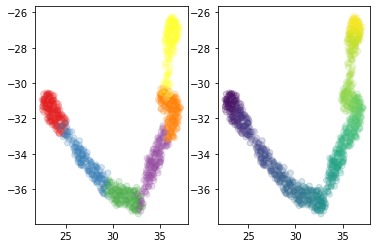

In [9]:
data1 = ad.AnnData(np.log(X1+1))
pp.neighbors(data1, use_rep='X', n_neighbors=700)
umap(data1)
dm1 = data1.obsm["X_umap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(dm1[:, 0], dm1[:, 1], c=cm.Set1(indices1), alpha=0.2)
ax[1].scatter(dm1[:, 0], dm1[:, 1], c=labs1, alpha=0.2)

To simulate metastable states we need to have parts of the process that contain more cells. We can do this by either supplying a density that varies along pseudotime or by sampling more cells around certain pseudotime points.

We choose the middle of each branch as a metastable state. The standard deviation denotes how fast cells move through the state (the higher the faster). The first four states are relatively similar, the fifth is faster and the sixth is slower.

In [10]:
states = np.arange(15, t.get_max_time(), 30)
state_std = [7, 7, 7, 7, 10, 5]
X2, labs2, brns2, scalings2 = sim.sample_pseudotime_series(t, 300, states, state_std, alpha=alpha, beta=beta)
# normalize gene expression by library size
X2 = (X2.transpose() / scalings2).transpose()

The distribution of sample pseudotime values reflects the choice of pseudotime and variance for each metastable state.

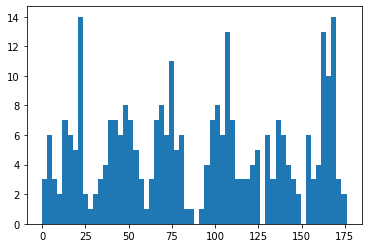

In [11]:
fig, ax = plt.subplots()
h = ax.hist(labs2, bins=60)

The UMAP for this simulation still reflects the underlying structure of the process.

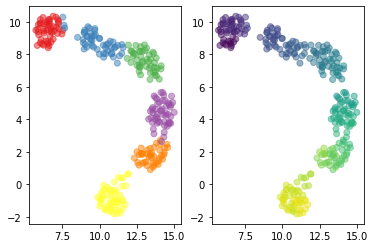

In [12]:
data2 = ad.AnnData(np.log(X2+1))
pp.neighbors(data2, use_rep='X', n_neighbors=100)
umap(data2)
dm2 = data2.obsm["X_umap"]
br_names2, indices2 = np.unique(brns2, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(dm2[:, 0], dm2[:, 1], c=cm.Set1(indices2), alpha=0.5)
ax[1].scatter(dm2[:, 0], dm2[:, 1], c=labs2, alpha=0.5)

When reducing the variance of the gene expression to Poisson (variance equals mean) the process becomes even more visible:

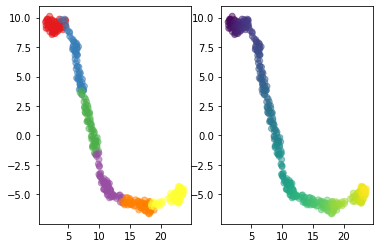

In [13]:
alpha_poisson = 0
beta_poisson = 1 + 10e-9

X3, labs3, brns3, scalings3 = sim.sample_whole_tree(t, 2, alpha=alpha_poisson, beta=beta_poisson)

# normalize gene expression by library size
X3 = (X3.transpose() / scalings3).transpose()

data3 = ad.AnnData(np.log(X3+1))
pp.neighbors(data3, use_rep='X')
umap(data3)
dm3 = data3.obsm["X_umap"]
br_names3, indices3 = np.unique(brns3, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(dm3[:, 0], dm3[:, 1], c=cm.Set1(indices3), alpha=0.5)
ax[1].scatter(dm3[:, 0], dm3[:, 1], c=labs3, alpha=0.5)